# Regressorion with Orbit - Advance I

In this demo, we want to demonstartate further how to config orbit to perform regressions with time-series analysis.  The config including different regularizations and we use a simulated data set to compare against ground truth. 

__IMPORTANT:__ This notebook only works under python 3.6 due to a bug related to matplotlib.

In [2]:
import pandas as pd
import numpy as np
import scipy
import gc

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import pystan

from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull

from orbit.diagnostics.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative

In [3]:
# randomization is using numpy with this version
print("np version: {}".format(np.__version__))
print("scipy version: {}".format(scipy.__version__))
print("pystan version: {}".format(pystan.__version__))

np version: 1.19.0
scipy version: 1.2.0
pystan version: 2.19.1.1


## Simulation of Regression with Trend

Let's make a vanila problem with observation(t) = trend(t) + regression

In [5]:
# To scale regressor values in a nicer way
REG_BASE = 1000
SEED = 2020
NUM_OF_REGRESSORS = 5
COEFS= np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)
COEFS

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [5]:
raw_df, trend, seas, coefs = make_ts_multiplicative(
    series_len=200, seasonality=52, coefs=COEFS,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=1.0,
    regression_sparsity=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)
coefs

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [6]:
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,date
0,1865.0,0.0,1842.0,2548.0,1047.0,0.0,2016-01-10
1,1680.0,1755.0,1858.0,1871.0,912.0,0.0,2016-01-17
2,2390.0,1429.0,2055.0,1936.0,1974.0,1765.0,2016-01-24
3,984.0,0.0,1272.0,1469.0,0.0,3932.0,2016-01-31
4,1259.0,2447.0,0.0,819.0,1753.0,2383.0,2016-02-07


In [7]:
print(coefs)

[ 0.15602066  0.05231785  0.16325487 -0.11182046  0.0027203 ]


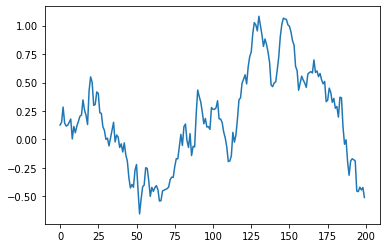

In [8]:
plt.plot(trend)

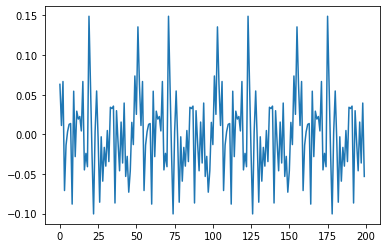

In [9]:
plt.plot(seas)

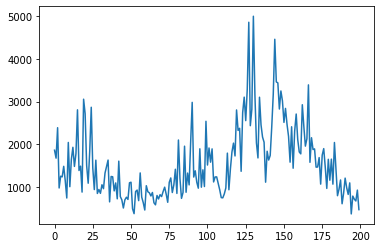

In [10]:
plt.plot(raw_df['response'])

## Estimating Coefficients I - full relevance

Assume we observe the data frame `df` and the scaler `REG_BASE`

In [8]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [9]:
mod_auto_ridge = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
mod_fixed_ridge1 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.5] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
mod_fixed_ridge2 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.05] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1._posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2._posterior_samples['rr_beta'], axis=0)

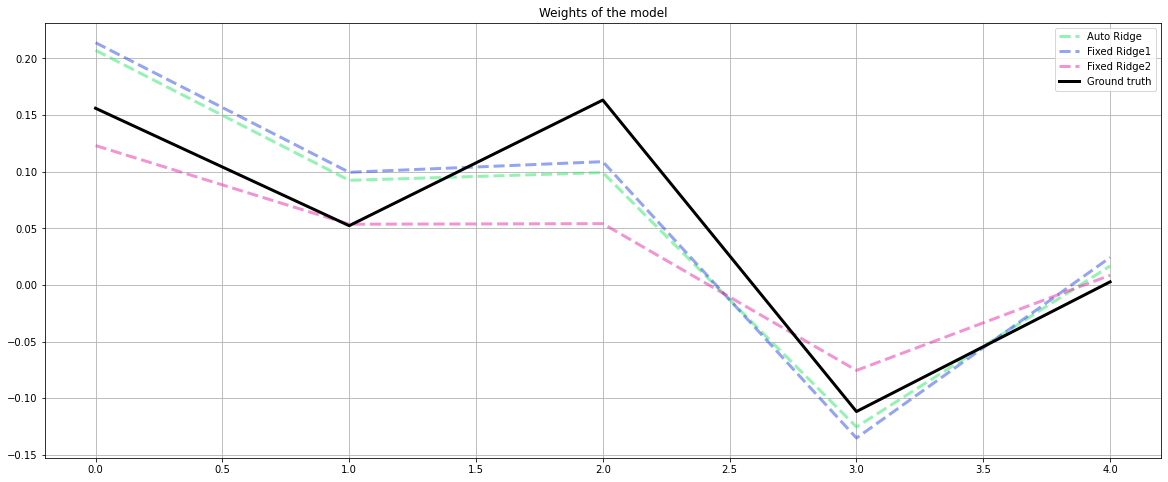

In [14]:
lw=3
plt.figure(figsize=(20, 8))
plt.title("Weights of the model")
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

The result looks reasonable to the true coefficients.

## Checking Model Convergence and Posterior Distribution

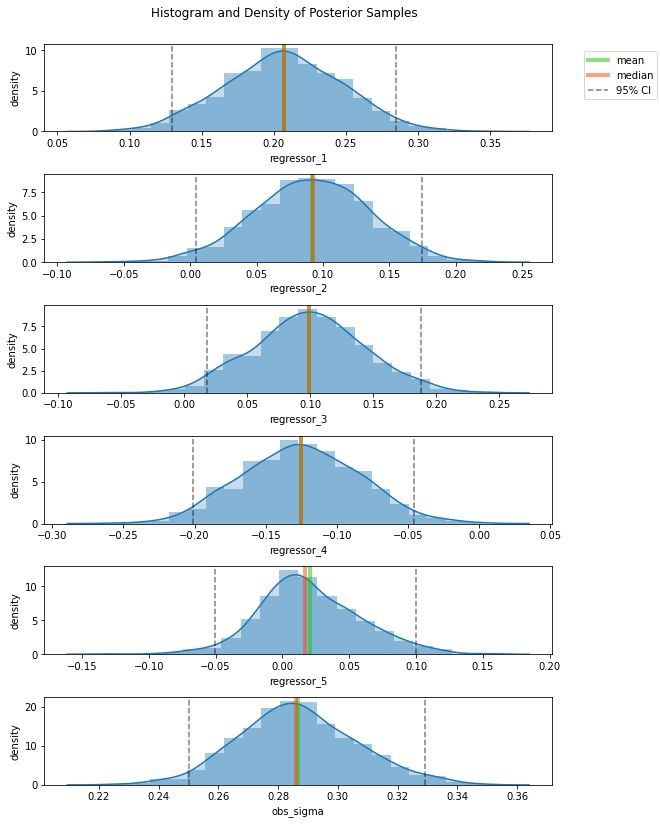

In [15]:
_ = plot_posterior_params(mod_auto_ridge, kind='density')

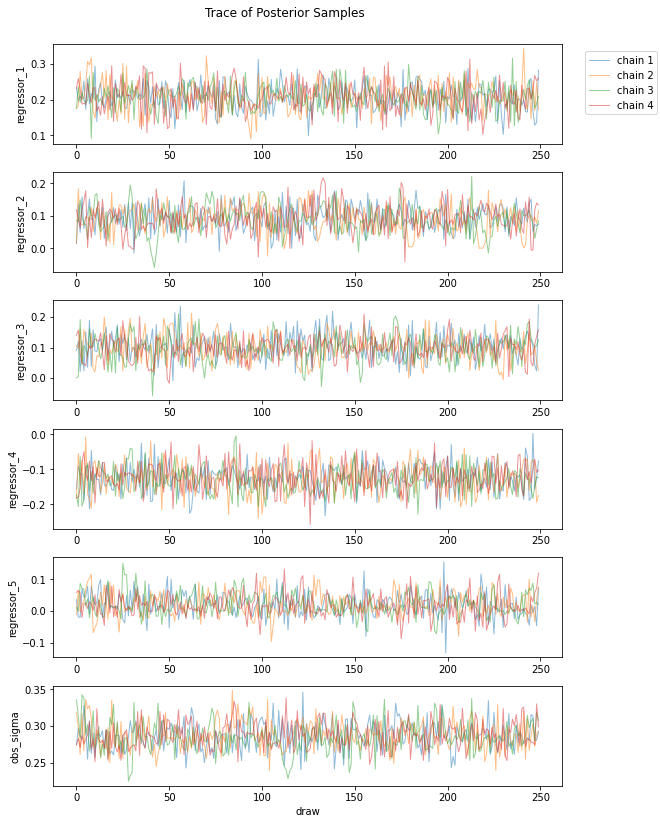

In [16]:
_ = plot_posterior_params(mod_auto_ridge, kind='trace')

## Estimating Coefficients II - high sparsity

In [6]:
NUM_OF_REGRESSORS = 25
REG_RELEVANCE = 0.8
COEFS= np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)
COEFS

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ,
        0.0366778 ,  0.05510171,  0.05726848, -0.14605049,  0.13879701,
       -0.0262531 ,  0.08841281,  0.06847838,  0.07490149,  0.03854218,
        0.1632666 , -0.0597671 , -0.01806245, -0.05170049,  0.32790427,
        0.14872741, -0.02134489, -0.17082483,  0.0363513 ,  0.13933526])

In [7]:
raw_df, trend, seas, coefs = make_ts_multiplicative(
    series_len=200, seasonality=52, coefs=COEFS, regressor_relevance=REG_RELEVANCE,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=1.0,
    regression_sparsity=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,...,regressor_17,regressor_18,regressor_19,regressor_20,regressor_21,regressor_22,regressor_23,regressor_24,regressor_25,date
0,2777.0,0.0,1842.0,2548.0,1047.0,0.0,1755.0,1858.0,1871.0,912.0,...,1272.0,1469.0,0.0,3932.0,2447.0,0.0,819.0,1753.0,2383.0,2016-01-10
1,1623.0,0.0,0.0,1685.0,1146.0,0.0,1315.0,1771.0,0.0,0.0,...,1352.0,2183.0,1198.0,1432.0,1030.0,1262.0,1887.0,0.0,2649.0,2016-01-17
2,2856.0,0.0,0.0,791.0,0.0,0.0,1805.0,0.0,1685.0,1179.0,...,0.0,2223.0,1749.0,1745.0,1751.0,0.0,2092.0,0.0,1701.0,2016-01-24
3,872.0,2278.0,0.0,1707.0,0.0,2369.0,1234.0,0.0,1842.0,0.0,...,1419.0,0.0,1273.0,0.0,0.0,1334.0,0.0,1579.0,2985.0,2016-01-31
4,1181.0,1630.0,0.0,0.0,0.0,973.0,0.0,0.0,1295.0,1452.0,...,2595.0,2804.0,0.0,0.0,1906.0,1930.0,1312.0,0.0,2237.0,2016-02-07


In [8]:
print(coefs)

[ 0.          0.05231785  0.         -0.11182046  0.          0.
  0.          0.          0.          0.13879701  0.          0.
  0.          0.07490149  0.          0.          0.          0.
  0.          0.32790427  0.          0.          0.          0.
  0.        ]


In [9]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [10]:
mod_lasso = DLTMAP(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

In [11]:
mod_auto_ridge = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [13]:
mod_fixed_ridge1 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
mod_fixed_ridge2 = DLTFull(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.1] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [16]:
coef_lasso = np.median(mod_lasso._posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1._posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2._posterior_samples['rr_beta'], axis=0)

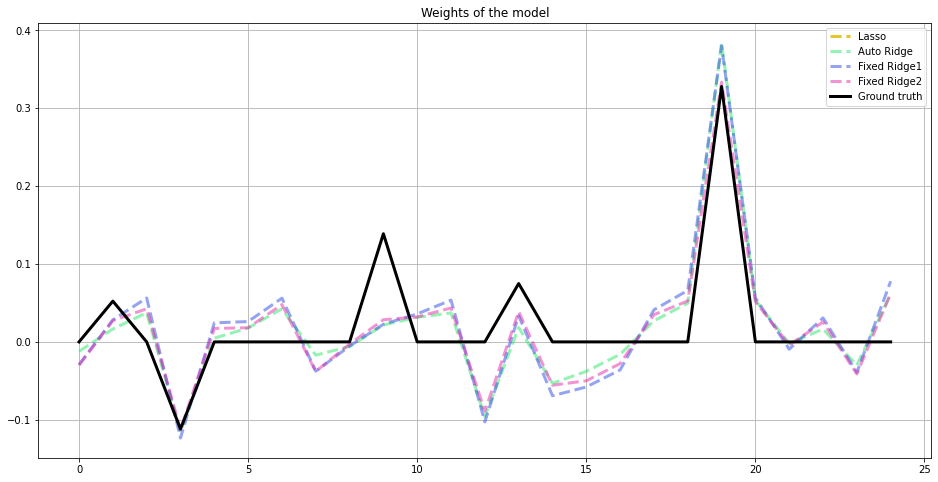

In [17]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=1.0, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

Again, with high dimensional data, the result looks reasonable to the true coefficients with irrelevant regressors fed into the model.